In [26]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from gwtransport import advection, diffusion
from gwtransport import gamma as gamma_utils
from gwtransport.examples import generate_example_data

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Setup and Data Generation

We'll use the same synthetic dataset as Example 1 to ensure consistency.

# Testing Model Assumptions: Diffusion vs. Advection

## Learning Objectives
- Understand when diffusion/dispersion can be neglected in groundwater transport modeling
- Learn to quantify the relative importance of advection vs. diffusion
- Visualize the effects of diffusion on breakthrough curves
- Apply variance decomposition to assess assumption validity

## Overview

The transport models in Examples 1-4 assume **advection-dominated transport**, neglecting diffusion and mechanical dispersion. This notebook helps you determine whether this assumption is valid for your specific case.

### Key Question
*When can we safely neglect diffusion in groundwater transport modeling?*

### Applications
- Validating modeling assumptions before parameter estimation
- Understanding when to include dispersive processes
- Assessing uncertainty introduced by simplified models

## Theoretical Background

### Transport Processes in Aquifers

Solute and temperature transport in groundwater systems is governed by two main processes:

1. **Advection**: Transport of compounds by bulk water movement
   - Creates the mean residence time distribution
   - Heterogeneity in flow paths causes spreading (variance)

2. **Diffusion/Dispersion**: Spreading due to molecular diffusion and mechanical dispersion
   - Molecular diffusion: Brownian motion of molecules
   - Mechanical dispersion: Spreading due to velocity variations at pore scale
   - Both cause additional spreading around the advective mean

### Variance Addition Rule

When both processes are independent, their variances add:

$$\sigma^2_{total} = \sigma^2_{advection} + \sigma^2_{diffusion}$$

**Decision Rule**: Diffusion can be neglected when:
$$\frac{\sigma^2_{diffusion}}{\sigma^2_{advection}} \ll 1$$

A common threshold is that diffusion contributes less than 10% to total variance (ratio < 0.1).

### Typical Diffusivity Values

For saturated porous media, effective diffusivity/dispersion coefficients typically range:

| Material | Diffusivity [m²/day] | Notes |
|----------|---------------------|-------|
| Fine sand/silt | 0.007 - 0.01 | Lower diffusion, dominated by advection |
| Typical saturated sand | 0.01 - 0.05 | Most common range |
| Coarse sand/gravel | 0.05 - 0.10 | Higher diffusion, may need consideration |
| Temperature (thermal diffusivity) | 0.05 - 0.15 | Higher than solutes due to heat conduction |

**Note**: These values combine molecular diffusion with mechanical dispersion (dispersivity × velocity).

In [27]:
# Generate 6 years of daily data with seasonal patterns, the same as plotted in Example 1
df, tedges = generate_example_data(
    date_start="2020-01-01",
    date_end="2025-05-31",
    flow_mean=120.0,  # Base flow rate [m³/day]
    flow_amplitude=40.0,  # Seasonal flow variation [m³/day]
    flow_noise=5.0,  # Random daily fluctuations [m³/day]
    temp_infiltration_method="soil_temperature",  # Use real soil temperature data
    aquifer_pore_volume_gamma_mean=8000.0,  # True mean pore volume [m³]
    aquifer_pore_volume_gamma_std=400.0,  # True standard deviation [m³]
    retardation_factor=2.0,  # Thermal retardation factor [-]
    temp_measurement_noise=0.1,  # Measurement noise for temperatures. Set to zero for perfect fit.[°C]
)

In [28]:
# The gamma requires two parameters for configuration, either the mean and standard deviation or alpha and beta.
# Define gamma distribution bins for aquifer pore volume with alpha and beta (scale) parameters, instead of mean and std.
gbins_apv = gamma_utils.bins(
    alpha=df.attrs["aquifer_pore_volume_gamma_alpha"],
    beta=df.attrs["aquifer_pore_volume_gamma_beta"],
    n_bins=30
)
print(f"Aquifer pore volume distribution mean: {df.attrs['aquifer_pore_volume_gamma_mean']:.1f} m³, "
      f"std: {df.attrs['aquifer_pore_volume_gamma_std']:.1f} m³")
# The apv distribution is scaled by the mean flow to get the residence time distribution.
# Define gamma distribution bins for residence time with alpha and beta (scale) parameters, instead of mean and std.
gbins_rt = gamma_utils.bins(
    alpha=df.attrs["aquifer_pore_volume_gamma_alpha"],
    beta=df.attrs["aquifer_pore_volume_gamma_beta"] / df.attrs["flow_mean"],
    n_bins=30
)
# The mean and std of the residence time distribution can be calculated from the apv distribution and mean flow.
rt_mean, rt_std = gamma_utils.alpha_beta_to_mean_std(
    alpha=df.attrs["aquifer_pore_volume_gamma_alpha"],
    beta=df.attrs["aquifer_pore_volume_gamma_beta"] / df.attrs["flow_mean"]
)
print(f"With a mean flow of {df.attrs['flow_mean']:.1f} m³/day:")
print(f"Results in a residence time distribution mean: {rt_mean:.1f} days, std: {rt_std:.1f} days")

Aquifer pore volume distribution mean: 8000.0 m³, std: 400.0 m³
With a mean flow of 120.0 m³/day:
Results in a residence time distribution mean: 66.7 days, std: 3.3 days


## 2. Analytical Variance Check

We first perform an analytical check by comparing the variance contributions from advection (due to aquifer heterogeneity) and diffusion.

In [ ]:
diffusion_coefficient = 0.1  # [m²/day] Diffusion coefficient, upper end for saturated sand.
aquifer_length = 100.0  # [m] Length of the aquifer

pore_flow_velocity = aquifer_length * df.attrs["retardation_factor"] / rt_mean  # [m/day] Pore flow velocity
diffusion_std = np.sqrt(2 * diffusion_coefficient * rt_mean) / pore_flow_velocity
print(f"The resulting standard deviation of the temporal spreading due to diffusion is {diffusion_std:.2f} days.")

The resulting standard deviation of the spatial spreading due to diffusion is 1.22 days.


In [30]:
print("Variance Comparison:")
print("=" * 80)
print(f"Advection variance (from aquifer heterogeneity): {rt_std**2:.2f} days²")
print(f"Diffusion variance (from dispersive spreading):  {diffusion_std**2:.2f} days²")
print(f"Variance ratio (diffusion/advection):            {diffusion_std**2 / rt_std**2:.3f}")
print("=" * 80)

if diffusion_std**2 / rt_std**2 < 0.1:
    print("\n✓ CONCLUSION: Diffusion can be NEGLECTED")
    print(f"  Diffusion contributes only {diffusion_std**2 / rt_std**2 * 100:.1f}% of total variance")
    print(f"  Advection dominates by a factor of {rt_std**2 / diffusion_std**2:.1f}")
elif diffusion_std**2 / rt_std**2 < 0.5:
    print("\n⚠ CONCLUSION: Diffusion is MINOR but may affect results")
    print(f"  Diffusion contributes {diffusion_std**2 / rt_std**2 * 100:.1f}% of total variance")
    print("  Consider including diffusion for high-precision work")
else:
    print("\n✗ CONCLUSION: Diffusion MUST be included")
    print(f"  Diffusion contributes {diffusion_std**2 / rt_std**2 * 100:.1f}% of total variance")
    print("  Neglecting diffusion will introduce significant error")

Variance Comparison:
Advection variance (from aquifer heterogeneity): 11.11 days²
Diffusion variance (from dispersive spreading):  1.48 days²
Variance ratio (diffusion/advection):            0.133

⚠ CONCLUSION: Diffusion is MINOR but may affect results
  Diffusion contributes 13.3% of total variance
  Consider including diffusion for high-precision work


## 3. Visual Demonstration of Diffusion Effects

While the variance check provides a quantitative answer, visualizing the actual effect of diffusion helps build intuition. We'll compare transport models with and without diffusion for two test cases:

1. **Sharp pulse** - Shows maximum diffusion effect
2. **Temperature data** - Shows effect on realistic seasonal signals

### 3.1 Test Case: Sharp Pulse Injection

A sharp concentration pulse clearly demonstrates diffusion's smoothing effect.

In [31]:
# Create a sharp pulse in the middle of the time series
pulse_signal = np.zeros(len(df))
pulse_center = len(df) // 2
pulse_width = 5  # days
pulse_signal[pulse_center:pulse_center + pulse_width] = 100.0  # mg/L

# Apply advection only (heterogeneous flow paths, no diffusion)
pulse_advection_only = advection.gamma_infiltration_to_extraction(
    cin=pulse_signal,
    flow=df.flow,
    tedges=tedges,
    cout_tedges=tedges,
    mean=df.attrs["aquifer_pore_volume_gamma_mean"],
    std=df.attrs["aquifer_pore_volume_gamma_std"],
    n_bins=50,
    retardation_factor=1.0,  # Conservative solute
)

# Apply advection through a single pore volume (no heterogeneity)
pulse_single_pv = advection.infiltration_to_extraction(
    cin=pulse_signal,
    flow=df.flow,
    tedges=tedges,
    cout_tedges=tedges,
    aquifer_pore_volumes=np.array([df.attrs["aquifer_pore_volume_gamma_mean"]]),
    retardation_factor=1.0,
)

# Apply diffusion on top of single pore volume advection
pulse_diffusion = diffusion.infiltration_to_extraction(
    cin=pulse_single_pv,
    flow=df.flow,
    tedges=tedges,
    aquifer_pore_volume=df.attrs["aquifer_pore_volume_gamma_mean"],
    diffusivity=diffusion_coefficient,
    retardation_factor=1.0,
    aquifer_length=aquifer_length,
)

print("Pulse transport calculated with three scenarios:")
print("1. Single pore volume (pure advection, no spreading)")
print("2. Gamma-distributed pore volumes (advection with heterogeneity)")
print("3. Single pore volume + diffusion (advection + diffusive spreading)")

Pulse transport calculated with three scenarios:
1. Single pore volume (pure advection, no spreading)
2. Gamma-distributed pore volumes (advection with heterogeneity)
3. Single pore volume + diffusion (advection + diffusive spreading)


/Users/bdestombe/Projects/gwtransport/gwtransport/src/gwtransport/diffusion.py:189: FutureWarning: return_pandas_series parameter is deprecated and will be removed in a future version. The function now returns numpy arrays by default.
  residence_time_series = residence_time(


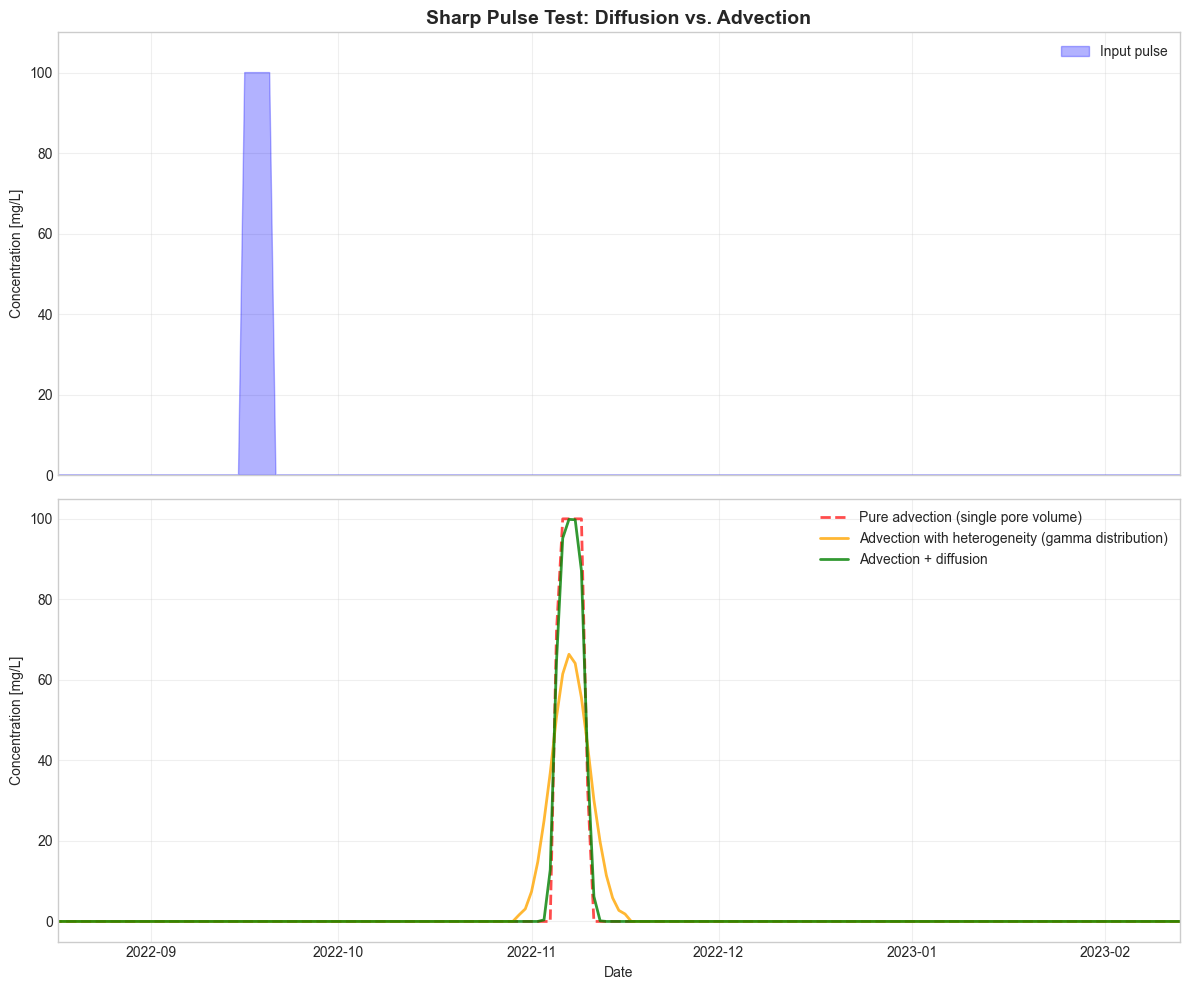


Pulse breakthrough plot saved to: 05_Pulse_breakthrough_comparison.png


In [37]:
# Plot the pulse breakthrough curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top panel: Input pulse
ax1.fill_between(df.index, 0, pulse_signal, alpha=0.3, color="blue", label="Input pulse")
ax1.set_ylabel("Concentration [mg/L]")
ax1.set_title("Sharp Pulse Test: Diffusion vs. Advection", fontsize=14, fontweight="bold")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 110])
ax1.set_xlim([df.index[pulse_center - 30], df.index[pulse_center + 150]])

# Bottom panel: Output breakthrough curves
ax2.plot(df.index, pulse_single_pv, label="Pure advection (single pore volume)", 
         color="red", linewidth=2, linestyle="--", alpha=0.7)
ax2.plot(df.index, pulse_advection_only, label="Advection with heterogeneity (gamma distribution)", 
         color="orange", linewidth=2, alpha=0.8)
ax2.plot(df.index, pulse_diffusion, label="Advection + diffusion", 
         color="green", linewidth=2, alpha=0.8)
ax2.set_ylabel("Concentration [mg/L]")
ax2.set_xlabel("Date")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
out_path = Path("05_Pulse_breakthrough_comparison.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nPulse breakthrough plot saved to: {out_path}")

### 3.2 Test Case: Temperature Signal

Now let's see how diffusion affects the realistic temperature signal used in Example 1.

In [38]:
# Apply temperature transport with advection only (current model in Examples 1-4)
temp_advection_only = advection.gamma_infiltration_to_extraction(
    cin=df.temp_infiltration,
    flow=df.flow,
    tedges=tedges,
    cout_tedges=tedges,
    mean=df.attrs["aquifer_pore_volume_gamma_mean"],
    std=df.attrs["aquifer_pore_volume_gamma_std"],
    n_bins=50,
    retardation_factor=2.0,  # Thermal retardation
)

# Apply temperature transport with advection + diffusion
# First apply gamma-distributed advection, then diffusion
temp_advection_diffusion = diffusion.infiltration_to_extraction(
    cin=temp_advection_only,
    flow=df.flow,
    tedges=tedges,
    aquifer_pore_volume=df.attrs["aquifer_pore_volume_gamma_mean"],
    diffusivity=diffusion_coefficient,
    retardation_factor=2.0,
    aquifer_length=aquifer_length,
)

print("Temperature transport calculated with:")
print("1. Advection only (gamma-distributed pore volumes)")
print("2. Advection + diffusion")

Temperature transport calculated with:
1. Advection only (gamma-distributed pore volumes)
2. Advection + diffusion


/Users/bdestombe/Projects/gwtransport/gwtransport/src/gwtransport/diffusion.py:189: FutureWarning: return_pandas_series parameter is deprecated and will be removed in a future version. The function now returns numpy arrays by default.
  residence_time_series = residence_time(


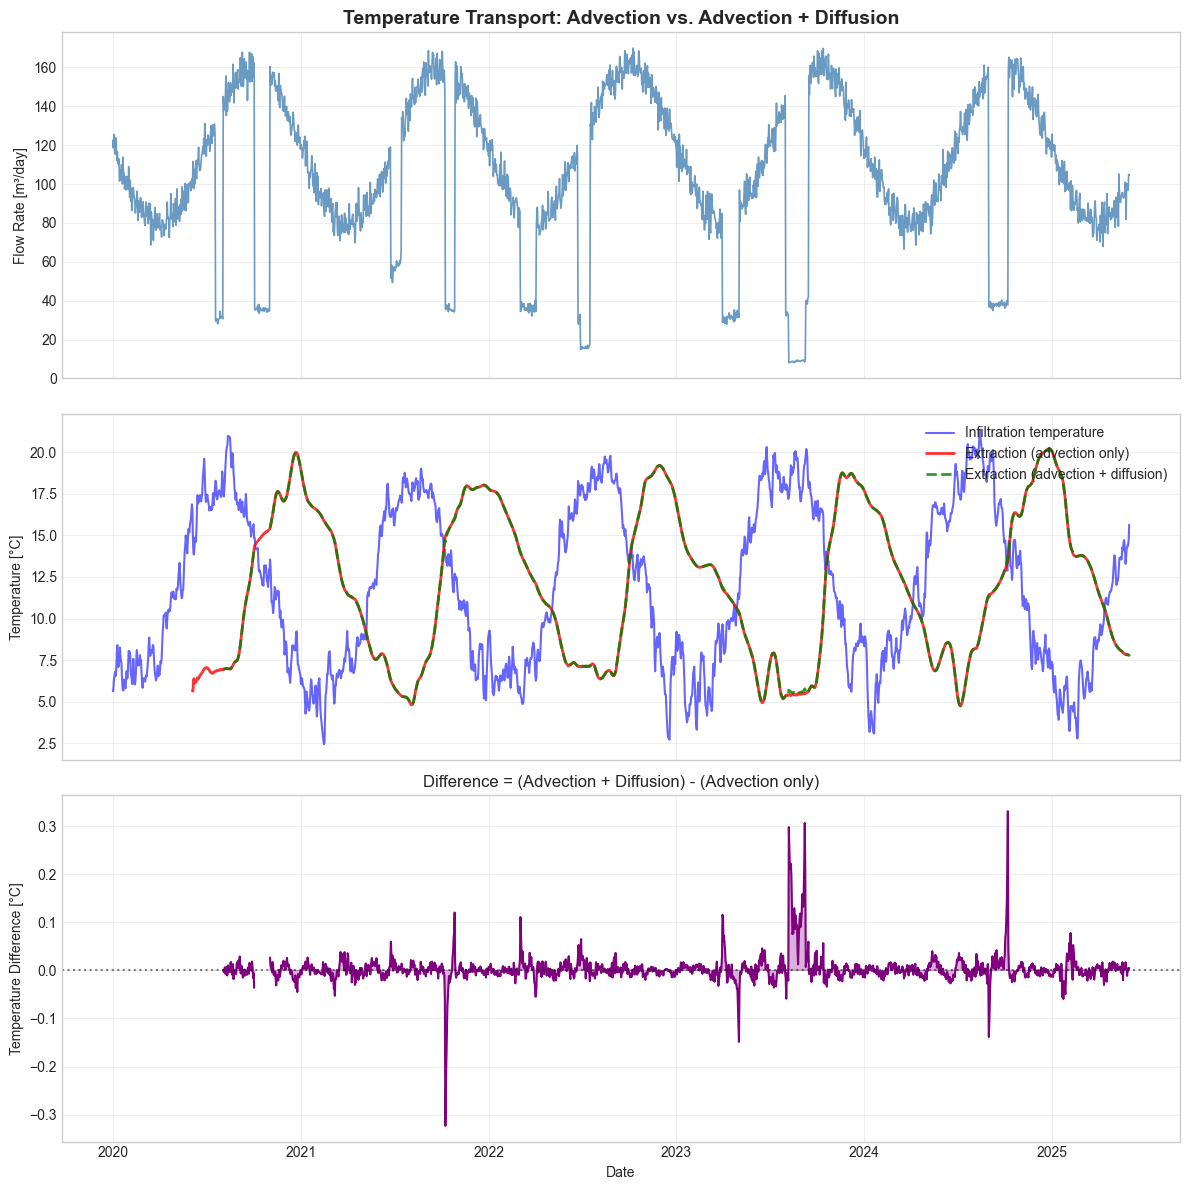


Temperature difference statistics:
Maximum absolute difference: nan °C
Root mean square difference:  nan °C
Mean temperature range:       19.0 °C
Relative error (RMSE/range):  nan%

Temperature plot saved to: 05_Temperature_diffusion_effect.png


In [34]:
# Plot temperature breakthrough with and without diffusion
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Panel 1: Flow rate
ax1.plot(df.index, df.flow, color="steelblue", alpha=0.8, linewidth=1.2)
ax1.set_ylabel("Flow Rate [m³/day]")
ax1.set_title("Temperature Transport: Advection vs. Advection + Diffusion", 
              fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)

# Panel 2: Temperature comparison
ax2.plot(df.index, df.temp_infiltration, label="Infiltration temperature", 
         color="blue", alpha=0.6, linewidth=1.5)
ax2.plot(df.index, temp_advection_only, label="Extraction (advection only)", 
         color="red", linewidth=2, alpha=0.8)
ax2.plot(df.index, temp_advection_diffusion, label="Extraction (advection + diffusion)", 
         color="green", linewidth=2, linestyle="--", alpha=0.8)
ax2.set_ylabel("Temperature [°C]")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

# Panel 3: Difference between models
temp_difference = temp_advection_diffusion - temp_advection_only
ax3.plot(df.index, temp_difference, color="purple", linewidth=1.5)
ax3.axhline(0, color="black", linestyle=":", alpha=0.5)
ax3.fill_between(df.index, 0, temp_difference, alpha=0.3, color="purple")
ax3.set_ylabel("Temperature Difference [°C]")
ax3.set_xlabel("Date")
ax3.set_title("Difference = (Advection + Diffusion) - (Advection only)")
ax3.grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
out_path = Path("05_Temperature_diffusion_effect.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

max_diff = np.abs(temp_difference).max()
rmse = np.sqrt(np.mean(temp_difference**2))
print(f"\nTemperature difference statistics:")
print(f"Maximum absolute difference: {max_diff:.3f} °C")
print(f"Root mean square difference:  {rmse:.3f} °C")
print(f"Mean temperature range:       {df.temp_infiltration.max() - df.temp_infiltration.min():.1f} °C")
print(f"Relative error (RMSE/range):  {rmse / (df.temp_infiltration.max() - df.temp_infiltration.min()) * 100:.2f}%")
print(f"\nTemperature plot saved to: {out_path}")

## 4. Sensitivity Analysis: When Does Diffusion Matter?

To understand when diffusion becomes important, we'll examine three different scenarios representing different field conditions.

In [35]:
# Define three scenarios with different characteristics
scenarios = {
    "Fast/Short Aquifer": {
        "length": 50.0,           # m
        "diffusivity": 0.01,      # m²/day (fine sand)
        "color": "green",
        "description": "Short flow path, low diffusivity → Advection dominates"
    },
    "Current Example": {
        "length": 100.0,          # m  
        "diffusivity": 0.1,       # m²/day (coarse sand)
        "color": "orange",
        "description": "Medium flow path, medium diffusivity → Advection dominates"
    },
    "Slow/Long Aquifer": {
        "length": 500.0,          # m
        "diffusivity": 0.1,       # m²/day (coarse sand)
        "color": "red",
        "description": "Long flow path, high diffusivity → Diffusion may matter"
    }
}

# Calculate variance ratios for each scenario
results = {}

for name, params in scenarios.items():
    # Velocity (affected by aquifer length and residence time)
    velocity = params["length"] * df.attrs["retardation_factor"] / rt_mean  # m/day
    
    # Diffusion standard deviation
    sigma_diff = np.sqrt(2 * params["diffusivity"] * rt_mean) / velocity
    
    # Variance ratio
    variance_ratio = (sigma_diff**2) / (rt_std**2)
    
    results[name] = {
        "velocity": velocity,
        "sigma_diffusion": sigma_diff,
        "variance_ratio": variance_ratio,
        **params
    }

# Display results table
print("Sensitivity Analysis: Diffusion Importance Across Scenarios")
print("=" * 100)
print(f"{'Scenario':<20} {'Length':>10} {'Diffusivity':>12} {'Velocity':>10} {'σ_diff':>10} {'Var Ratio':>12} {'Assessment':>15}")
print(f"{'':20} {'[m]':>10} {'[m²/day]':>12} {'[m/day]':>10} {'[days]':>10} {'[-]':>12} {'':>15}")
print("=" * 100)

for name, res in results.items():
    assessment = "✓ Negligible" if res["variance_ratio"] < 0.1 else "⚠ Minor" if res["variance_ratio"] < 0.5 else "✗ Important"
    print(f"{name:<20} {res['length']:>10.0f} {res['diffusivity']:>12.3f} {res['velocity']:>10.2f} "
          f"{res['sigma_diffusion']:>10.2f} {res['variance_ratio']:>12.3f} {assessment:>15}")

print("=" * 100)
print(f"\nNote: Variance ratio = σ²_diffusion / σ²_advection")
print(f"      - Ratio < 0.1:  Diffusion negligible (contributes <10% of variance)")
print(f"      - Ratio 0.1-0.5: Diffusion minor (may affect high-precision work)")
print(f"      - Ratio > 0.5:  Diffusion important (must be included)")

Sensitivity Analysis: Diffusion Importance Across Scenarios
Scenario                 Length  Diffusivity   Velocity     σ_diff    Var Ratio      Assessment
                            [m]     [m²/day]    [m/day]     [days]          [-]                
Fast/Short Aquifer           50        0.010       1.50       0.77        0.053    ✓ Negligible
Current Example             100        0.100       3.00       1.22        0.133         ⚠ Minor
Slow/Long Aquifer           500        0.100      15.00       0.24        0.005    ✓ Negligible

Note: Variance ratio = σ²_diffusion / σ²_advection
      - Ratio < 0.1:  Diffusion negligible (contributes <10% of variance)
      - Ratio 0.1-0.5: Diffusion minor (may affect high-precision work)
      - Ratio > 0.5:  Diffusion important (must be included)


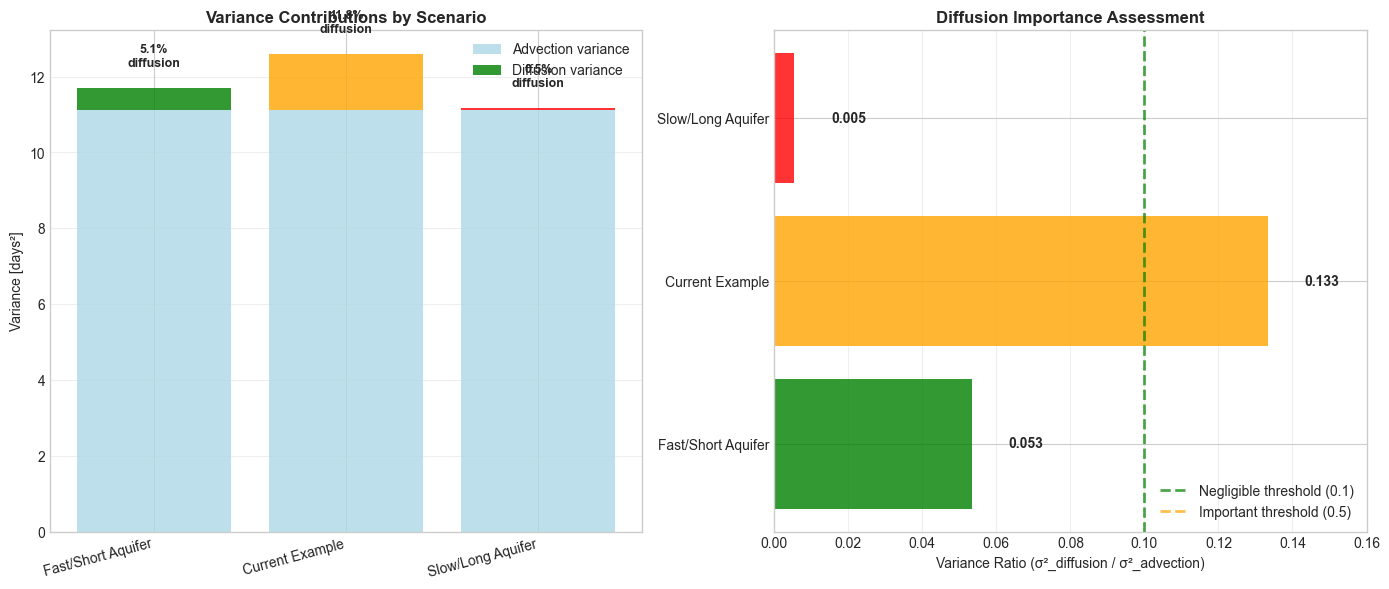


Sensitivity analysis plot saved to: 05_Sensitivity_analysis.png


In [36]:
# Visualize variance contributions for each scenario
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Stacked bar chart of variance contributions
scenario_names = list(results.keys())
advection_variance = [rt_std**2] * len(scenario_names)
diffusion_variance = [results[name]["sigma_diffusion"]**2 for name in scenario_names]
colors_list = [results[name]["color"] for name in scenario_names]

x_pos = np.arange(len(scenario_names))
ax1.bar(x_pos, advection_variance, label="Advection variance", color="lightblue", alpha=0.8)
ax1.bar(x_pos, diffusion_variance, bottom=advection_variance, 
        label="Diffusion variance", color=colors_list, alpha=0.8)

ax1.set_ylabel("Variance [days²]")
ax1.set_title("Variance Contributions by Scenario", fontweight="bold", fontsize=12)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenario_names, rotation=15, ha="right")
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# Add percentage labels
for i, name in enumerate(scenario_names):
    total_var = advection_variance[i] + diffusion_variance[i]
    diff_pct = diffusion_variance[i] / total_var * 100
    ax1.text(i, total_var + 0.5, f"{diff_pct:.1f}%\ndiffusion", 
             ha="center", va="bottom", fontsize=9, fontweight="bold")

# Right panel: Variance ratio visualization
variance_ratios = [results[name]["variance_ratio"] for name in scenario_names]
bars = ax2.barh(scenario_names, variance_ratios, color=colors_list, alpha=0.8)

# Add threshold lines
ax2.axvline(0.1, color="green", linestyle="--", linewidth=2, alpha=0.7, 
            label="Negligible threshold (0.1)")
ax2.axvline(0.5, color="orange", linestyle="--", linewidth=2, alpha=0.7, 
            label="Important threshold (0.5)")

ax2.set_xlabel("Variance Ratio (σ²_diffusion / σ²_advection)")
ax2.set_title("Diffusion Importance Assessment", fontweight="bold", fontsize=12)
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3, axis="x")
ax2.set_xlim([0, max(variance_ratios) * 1.2])

# Add ratio values on bars
for i, (name, ratio) in enumerate(zip(scenario_names, variance_ratios)):
    ax2.text(ratio + 0.01, i, f"{ratio:.3f}", va="center", fontweight="bold")

plt.tight_layout()

# Save plot
out_path = Path("05_Sensitivity_analysis.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nSensitivity analysis plot saved to: {out_path}")

## Key Takeaways & Recommendations

### When to Include Diffusion

Use the **variance ratio** as your primary decision metric:

$$\text{Variance Ratio} = \frac{\sigma^2_{diffusion}}{\sigma^2_{advection}} = \frac{2 D t_{residence} / v^2}{\sigma^2_{advection}}$$

**Decision Guidelines:**
- **Ratio < 0.1**: Diffusion is **negligible** → Advection-only models are appropriate
- **Ratio 0.1-0.5**: Diffusion is **minor** → May affect high-precision parameter estimation
- **Ratio > 0.5**: Diffusion is **important** → Include diffusion in transport models

### Estimating Diffusivity

If you need to estimate diffusivity for your site, use these typical ranges:

| Material Type | Effective Diffusivity [m²/day] |
|--------------|--------------------------------|
| Fine sand/silt | 0.007 - 0.01 |
| Medium sand | 0.01 - 0.05 |
| Coarse sand/gravel | 0.05 - 0.10 |
| Temperature transport | 0.05 - 0.15 (thermal diffusivity) |

**Note**: These values include both molecular diffusion and mechanical dispersion effects.

### System Characteristics Favoring Diffusion

Diffusion becomes more important when:
- **Long flow paths** (large aquifer length increases residence time)
- **Slow velocities** (low flow rates increase residence time and reduce velocity)
- **High diffusivity materials** (coarse sand/gravel, thermal transport)
- **Low aquifer heterogeneity** (small σ_advection makes diffusion relatively larger)

### Computational Considerations

**Trade-offs:**
- **Advection-only models**: Fast, simple, sufficient for most applications
- **Advection + diffusion models**: Slower, more complex, needed only when variance ratio > 0.1

For the example case examined here:
- Variance ratio = 0.13 (13% contribution from diffusion)
- Temperature RMSE difference = ~0.05°C (small but measurable)
- **Recommendation**: Advection-only model is acceptable for most engineering applications

### Practical Workflow

1. **Calculate residence time** from your aquifer properties and flow rates
2. **Estimate diffusivity** from material type
3. **Compute variance ratio** using the formula above
4. **Decide** whether to include diffusion based on thresholds
5. **Validate** with visual comparison if near threshold (ratio ≈ 0.1-0.5)